&nbsp;

# 11 - Analyse des extrêmes

---

&nbsp;

L'analyse des extrêmes est une étape diagnostic du système, c'est-à-dire qu'elle va compléter le raisonnement concernant ce que doit apprendre le modèle, comment il doit l'apprendre et avec quelles hypothèses. 

L'objectif est d'objectiver les évènements "rares". Cela passe l'étude de leur durée, leur persistance, leur répartition temporelle et spatiale, leur saisonnalité et l'éventuelle présence de non-linéarité.

Suite au notebook 06, on a observé un kurtosis de Fisher légèrement supérieur au standard gaussien (~0.83 > 0). La positivité de cet indicateur prouve assez fiablement que les extrêmes ne sont pas anecdotiques. C'est un argument légitime pour imposer une analyse des extrêmes.

&nbsp;

> #### Que désignons-nous comme les extrêmes ?

Les extrêmes sont des événements de queue, difficiles à prédire par des modèles calibrés sur la moyenne. Ils correspondent à la partie de la distribution la plus mal contrainte par les approches statistiques classiques. 

On la mènera sur les anomalies de SST détrendées afin d’assurer la stationnarité des statistiques et de se concentrer sur les mécanismes dynamiques pertinents pour la modélisation SciML. 

&nbsp;

Le rôle spécifique avant SciML (et plus généralement avant n'importe quel ML) de l'analyse est en fait de répondre à la question suivante :

> #### Qu'est-ce qui est difficile à prédire ?

La réponse simple est "les évènements exceptionnels". La plupart des modèles de ML vont assez facilement prédire les valeurs moyennes. En revanche, la précision va grandement s'atténuer concernant la survenue, la durée ou l'intensité des évènements rares.

C'est assez normal en fait. Car ils sont peu représentés dans les données, un modèle linéaire va donc peiner à prédire des évènements non-linéaires car ils ont souvent un équivalent-mémoire.

&nbsp;

---

&nbsp;

## 1. Choix méthodologiques pour les extrêmes

&nbsp;

Statistiquement, on dira qu'un évènement extrême est défini comme un dépassement d'un quantile élevé de la distribution.

Deux approches sont possibles. La première *quantile-based* définit un extrême comme suit : 

$$ X(t) > q_p $$

où $q_p$ est le quantile $p$ de la série analysée.

Les avantages sont multiples, cela garantie un nombre suffisant d'évènements pour l'analyse statistique et une certaine robustesse au biais de moyenne. On pourra, en revanche, moins interprété physiquement les implications.

Au contraire, la méthode par *seuil absolu* permet une interprétation physique directe car elle définit un extrême à partir d'un seuil fixé de l'unité physique de la variable :

$$ X(t) > S $$

où S peut être un seuil de SST absolue (comme 20°).

Cette méthode de définition présente quelques inconvénients. Elle est sensible aux biais et à la tendance, demande de justifier scientifiquement le choix du seuil et dépend fortement de la saison.

&nbsp;

> #### Quelle méthode choisir ?

Dans ce travail, on préfera définir les évènements extrêmes à partir d'une approche *quantile-based*.

Premièrement, car nous travaillons avec les anomalies de SST détrendées, et cette méthode est adaptée à la nature du jeu de donnée. Sous peine de devoir, en plus de trouver un seuil absolu justifiable, mettre en forme ce seuil pour qu'il corresponde aux anomalies et soit adapté au caractère désaisonnalisé.

Deuxièmement, nous avons la volonté de nous concentrer sur la variabilité dynamique et la nécessité d'assurer la stationnarité statistique. L'approche par les quantiles permet de remplir ces deux critères.

On retiendra 2 seuils standards : 
- Quantile à 5% - 95% : pour caractériser les évènements "fréquents"
- Quantile à 1% - 99% : pour analyser les évènements rares et intenses

&nbsp;

---

&nbsp;

## 2. Quantiles extrêmes

### 2.1 Distribution des anomalies avec seuil des extrêmes

Analysons basiquement la distribution en mettant en évidence les 2 seuils standards énoncés précédemment. Commençons par une analyse régionale, c'est-à-dire que nous allons moyenner spatialement avant d'analyser quelconque extrêmes locales (en pixel par pixel).

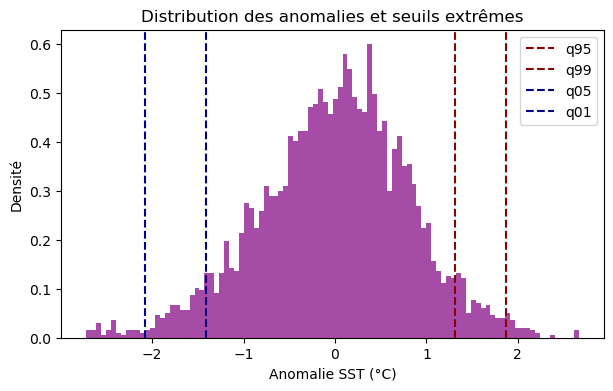

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Basic loading of processed SST data
ds = xr.open_dataset("data/processed/sstDeseasonalizedCOPERNICUS20102019.nc")
sst = ds["analysed_sst"]

# We generalize the computation of extreme thresholds over the entire region
sstReg = sst.mean(dim=("latitude", "longitude"))

# Computation of extreme quantiles
q95Reg = sstReg.quantile(0.95, dim="time")
q99Reg = sstReg.quantile(0.99, dim="time")

q1Reg = sstReg.quantile(0.01, dim="time")
q5Reg = sstReg.quantile(0.05, dim="time")

# Plotting the distribution of SST anomalies with extreme thresholds
plt.figure(figsize=(7, 4))
plt.hist(sstReg.values, bins=100, density=True, color="purple", alpha=0.7)
plt.axvline(q95Reg, linestyle="--", label="q95", color="darkred")
plt.axvline(q99Reg, linestyle="--", label="q99", color="darkred")
plt.axvline(q5Reg, linestyle="--", label="q05", color="darkblue")
plt.axvline(q1Reg, linestyle="--", label="q01", color="darkblue")
plt.xlabel("Anomalie SST (°C)")
plt.ylabel("Densité")
plt.legend()
plt.title("Distribution des anomalies et seuils extrêmes")
plt.show()

On continue de constater la légère asymmétrie entre les anomalies "chaudes" et "froides" (densité de probabilité plus dilaté sur les anomalies SST "froides"). 

Quantitativement, on ne remarque pas de déséquilibre flagrant entre évènements "rares" froid-chaud. La densité est relativement similaire sur les intervalles [0.01, 0.05] et [0.95, 0.99], bien que, dû à l'asymmétrie, les événèments "rares" sur l'intervalle "froid" (1% - 5%) sont distant de la valeur moyenne que pour ceux de l'intervalle "chaud" (95% - 99%).

Concernant les évènements "exceptionnels" (quantiles à 1% et 99%), on ne peut pour le moment rien dire, nous avons besoin de plus d'informations pour énoncer quelconques hypothèses.

&nbsp;

---

&nbsp;

### 2.2 Détection d'extrêmes "chauds" et "froids" locaux

Analysons désormais les extrêmes en pixel par pixel.

/nix/store/6n0y4lv7s2yld51nhh95kfd1wiqfd7si-python3-3.12.12-env/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


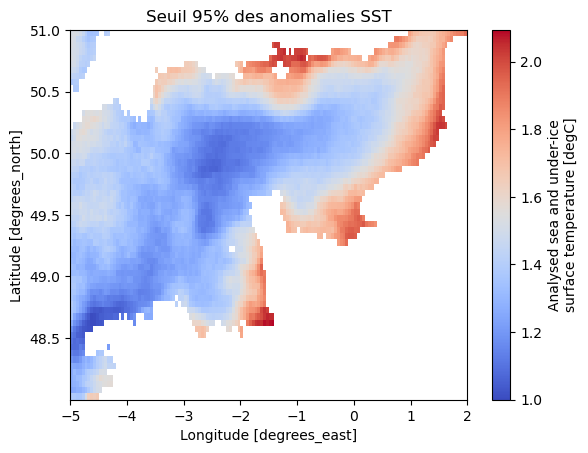

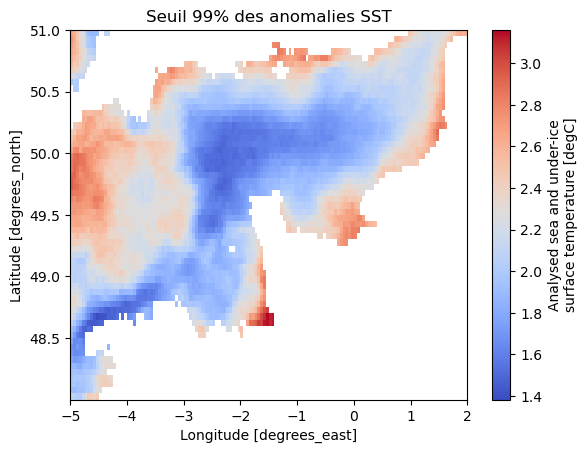

In [3]:
# Extremes analysis pixel-wise for hot events

q95 = sst.quantile(0.95, dim="time")
q99 = sst.quantile(0.99, dim="time")

q95.plot(cmap="coolwarm")
plt.title("Seuil 95% des anomalies SST")
plt.show()

q99.plot(cmap="coolwarm")
plt.title("Seuil 99% des anomalies SST")
plt.show()

Sans surprise, l'hétérogénéité spatiale est de mise. 

On observe des extrêmes locaux surtout au niveau des côtes ce qui est cohérent avec des évènements "rares" (95%) et "exceptionnels" (99%) de vagues de chaleur océaniques. Cela peut être lié à un ensemble de mécanismes connus : circulation côtière, faible profondeur, inertie thermique réduite (voir Compendium). 

On notera que des extrêmes locaux apparaissent à l'ouest de la carte pour les évènements exceptionnels (jonction entre la zone plus fermée et l'océan Atlantique). Cela pourrait correspondre à un important épisode de vagues de chaleur provenant de l'Atlantique.

Ce qu'on retiendra c'est l'interprétabilité physiquement logique constatée. Les évènements rares sont localisés et semblent être la conséquence de conditions dynamiques spécifiques à une échelle réduite. C'est un excellent indicateur de réalisme.

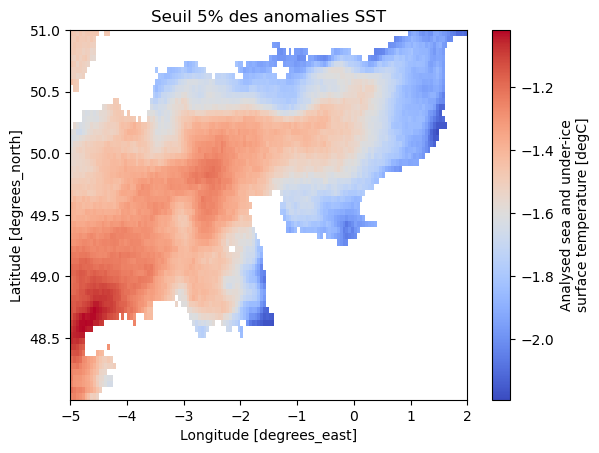

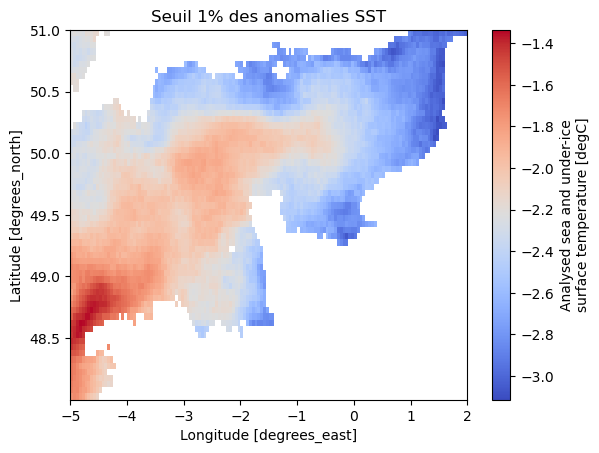

In [4]:
# Extremes analysis pixel-wise for cold events

q1 = sst.quantile(0.01, dim="time")
q5 = sst.quantile(0.05, dim="time")

q5.plot(cmap="coolwarm")
plt.title("Seuil 5% des anomalies SST")
plt.show()

q1.plot(cmap="coolwarm")
plt.title("Seuil 1% des anomalies SST")
plt.show()

C'est en observant ces deux cartes supplémentaires que l'on peut attester de la dynamique opposée entre chaud et froid.

La structuration spatiale des extrêmes est totalement inversée, les seuils froids sont franchies surtout au large côté Ouest-Atlantique. C’est totalement cohérent avec des refroidissements intenses, des intrusions d’eaux froides ou des événements hivernaux extrêmes. 

Ces phénomènes peuvent provoquer des extrêmes de fraîcheur se diffussa,t à l'échelle de la Manche à partir de l'océan Atlantique et cela fait sens avec les résultats observés.

&nbsp;

En comparant le 95ème percentile et le 99ème, puis le 5ème au 1er, on constate que plus l'évènement est rare plus il est localisé spatialement. Cela est également cohérent avec les dynamiques océaniques reconnues (voir Compendium).

&nbsp;

---

&nbsp;

### 2.3 Série temporelle des anomalies avec seuil des extrêmes

Ce qui serait désormais intéressant serait de déterminer comment se répartisse les évènements extrêmes "chauds" ou "froids" sur le plan temporelle, soit répondre au "Quand ?".



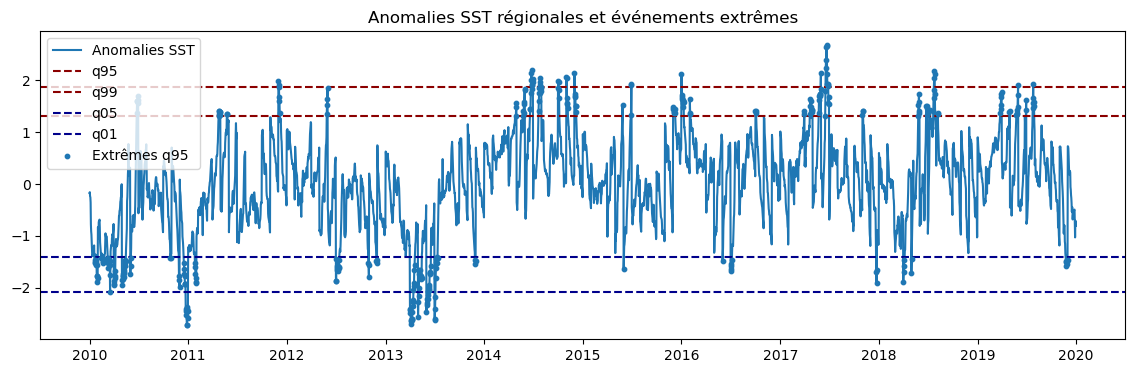

In [5]:
# We init cold and hot masks for the regional average
maskHot95 = sstReg >= q95Reg
maskCold05 = sstReg <= q5Reg

# We combine it to have a global mask of extremes
globalMask = maskHot95 | maskCold05

# We extract the extreme events
x = sstReg.time.where(globalMask, drop=True)
y = sstReg.where(globalMask, drop=True)

plt.figure(figsize=(14, 4))
plt.plot(sstReg.time, sstReg, label="Anomalies SST")

plt.axhline(q95Reg, linestyle="--", label="q95", color="darkred")
plt.axhline(q99Reg, linestyle="--", label="q99", color="darkred")

plt.axhline(q5Reg, linestyle="--", label="q05", color="darkblue")
plt.axhline(q1Reg, linestyle="--", label="q01", color="darkblue")

plt.scatter(
    x,
    y,
    s=10,
    label="Extrêmes q95",
    zorder=3
)

plt.legend()
plt.title("Anomalies SST régionales et événements extrêmes")
plt.show()



Ce n'est pas encore l'analyse de la saisonnalité des extrêmes mais l'on peut constater une certaine alternance-récurrence des extrêmes entre "chaud" et "froid". Ceux-ci sont rares mais récurrents (chaque année).

Ils sont relativement organisés temporellement, c'est-à-dire qu'on peut observer des "clusters" d'extrêmes correspondant à des évènements sur plusieurs jours consécutifs.

On remarque deux évènements de vague de froid qui se démarquent des autres l'un durant l'hiver 2010-2011, l'autre durant la première partie de 2013. Pour le chaud, on en remarque un en mi-2017. Voir Compendium si cela peut correspondre à des évènements météorologiques connus dans la région durant les mêmes périodes.

&nbsp;

La figure nous montre la persistance, la non-linéarité et la dépendance temporelle des extrêmes. Cette structure suggère une mémoire dynamique du système et justifie directement l’utilisation de modèles SciML capables de capturer les transitions de régime.

&nbsp;

---

&nbsp;

### 2.4 Détection des évènements continus et distribution des durées d'évènements

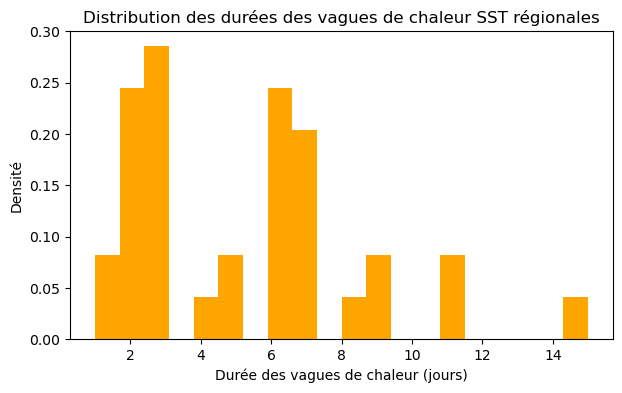

In [28]:
# We fix a threshold to analyze heatwave durations
isExtreme95 = sstReg > q95Reg

events = []
currentLength = 0

# We loop through the boolean series to find lengths of extreme events
for val in isExtreme95.values:
    if val:
        currentLength += 1
    else:
        if currentLength > 0:
            events.append(currentLength)
            currentLength = 0

# To catch an event ending at the last time step
if currentLength > 0:
    events.append(currentLength)

# Plotting the distribution of heatwave durations
plt.figure(figsize=(7, 4))
plt.hist(events, bins=20, density=True, color="orange")
plt.xlabel("Durée des vagues de chaleur (jours)")
plt.ylabel("Densité")
plt.title("Distribution des durées des vagues de chaleur SST régionales")
plt.show()


On constate qu'une majorité d'évènements durent entre 1 et 3 jours, et entre 6 et 7 jours, au-delà de 8 jours cela devient rare. La distribution semble suggérer que les vagues de chaleur peinent à persister.

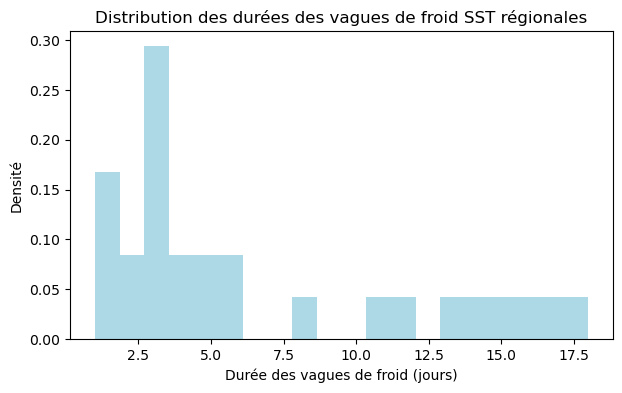

In [30]:

# Exactly the same for cold events

isExtreme05 = sstReg < q5Reg

events = []
currentLength = 0

for val in isExtreme05.values:
    if val:
        currentLength += 1
    else:
        if currentLength > 0:
            events.append(currentLength)
            currentLength = 0

if currentLength > 0:
    events.append(currentLength)

plt.figure(figsize=(7, 4))
plt.hist(events, bins=20, density=True, color="lightblue")
plt.xlabel("Durée des vagues de froid (jours)")
plt.ylabel("Densité")
plt.title("Distribution des durées des vagues de froid SST régionales")
plt.show()

On constate un pic d'évènement à court terme entre 1.5 et 6 jours. La queue est très étendu en durée, jusqu'à 18 jours. La distribution des évènements froids semblent donc suggérer une persistance plus forte sur la durée.

&nbsp;

---

&nbsp;

### 2.5 Visualisation durée contre intensité des épisodes extrêmes

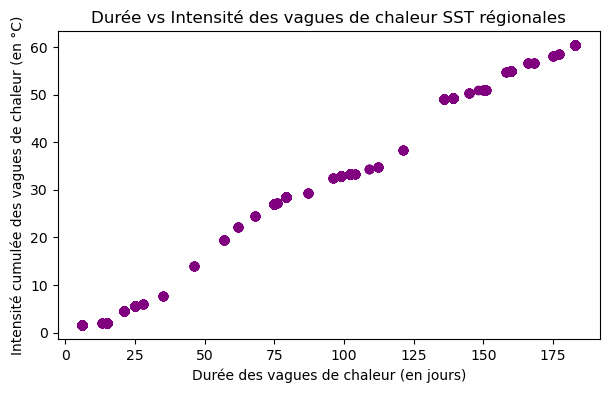

In [27]:

# We compute duration vs intensity for heatwaves

q95Val = q95Reg.item()

values = sstReg.values

events = []
intensities = []

currentLength = 0
currentIntensity = 0.0

# The idea is to loop through the SST values and accumulate length and intensity
for x in values:
    if x > q95Val:
        currentLength += 1
        currentIntensity += (x - q95Val)
    elif currentLength > 0:
        events.append(currentLength)
        intensities.append(currentIntensity)
        current_length = 0
        current_intensity = 0.0

# To catch an event ending at the last time step
if currentLength > 0:
    events.append(currentLength)
    intensities.append(currentIntensity)

events = np.array(events)
intensities = np.array(intensities)

# Then we are plotting duration vs intensity
plt.figure(figsize=(7, 4))
plt.scatter(events, intensities, color="purple")
plt.xlabel("Durée des vagues de chaleur (en jours)")
plt.ylabel("Intensité cumulée des vagues de chaleur (en °C)")
plt.title("Durée vs Intensité des vagues de chaleur SST régionales")
plt.show()


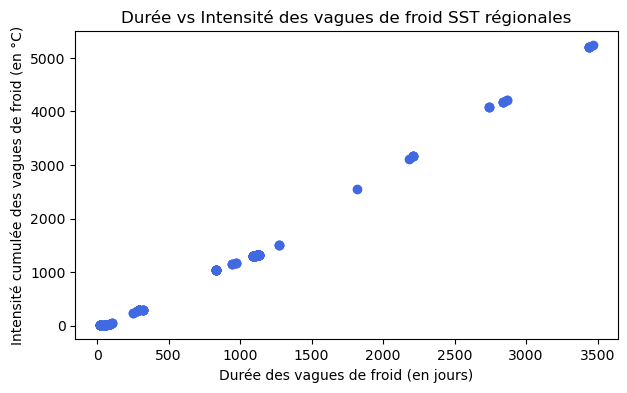

In [26]:
# Same for cold waves

q5Val = q5Reg.item()

values = sstReg.values

events = []
intensities = []

currentLength = 0
currentIntensity = 0.0

for x in values:
    if x > q5Val:
        currentLength += 1
        currentIntensity += (x - q5Val)
    elif currentLength > 0:
        events.append(currentLength)
        intensities.append(currentIntensity)
        current_length = 0
        current_intensity = 0.0

if currentLength > 0:
    events.append(currentLength)
    intensities.append(currentIntensity)

events = np.array(events)
intensities = np.array(intensities)

plt.figure(figsize=(7, 4))
plt.scatter(events, intensities, color="royalblue")
plt.xlabel("Durée des vagues de froid (en jours)")
plt.ylabel("Intensité cumulée des vagues de froid (en °C)")
plt.title("Durée vs Intensité des vagues de froid SST régionales")
plt.show()